### E10S Experiment 2 Beta 45 (without addons): INPUT_EVENT_RESPONSE_MS

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

32

In [3]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def compare_histogram(histogram, e10s, none10s, threshold):
    # Normalize individual histograms
    e10s = e10s.map(lambda x: x/x.sum())
    e10s = e10s.map(lambda x: x[x.index > threshold])
    none10s = none10s.map(lambda x: x/x.sum())
    none10s = none10s.map(lambda x: x[x.index > threshold])
    
    pvalue = grouped_permutation_test(chi2_distance, [e10s, none10s], num_samples=100)
    
    eTotal = e10s.sum()
    nTotal = none10s.sum()
        
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(len(e10s)), "non e10s ({} samples)".format(len(none10s))])

    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
        
    print "The probability that the distributions for {} are differing by chance is {:.2f}.".format(histogram, pvalue)

def normalize_uptime_hour(frame):
    frame = frame[frame["payload/simpleMeasurements/uptime"] > 0]
    frame = 60 * frame.apply(lambda x: x/frame["payload/simpleMeasurements/uptime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/uptime', axis=1, inplace=True)
    return frame
    
def compare_count_histograms(pings, *histograms_names):
    properties = histograms_names + ("payload/simpleMeasurements/uptime", "e10s")

    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())

    e10s = frame[frame["e10s"] == True]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["e10s"] == False]
    none10s = normalize_uptime_hour(none10s)
    
    for histogram in e10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        compare_scalars(histogram + " per hour", e10s[histogram].dropna(), none10s[histogram].dropna())

        
def compare_histograms(pings, threshold, *histogram_names):
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s",) , with_processes=True).collect())
    e10s = frame[frame["e10s"] == True]
    none10s = frame[frame["e10s"] == False]
    for histogram in none10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        has_children = np.sum(e10s[histogram + "_children"].notnull()) > 0
        has_parent = np.sum(e10s[histogram + "_parent"].notnull()) > 0
        
        if has_children and has_parent:
            compare_histogram(histogram + " (parent + children)", e10s[histogram].dropna(), none10s[histogram].dropna(), threshold)
            
        if has_parent:
            compare_histogram(histogram + " (parent)", e10s[histogram + "_parent"].dropna(), none10s[histogram].dropna(), threshold)
            
        if has_children:
            compare_histogram(histogram + " (children)", e10s[histogram + "_children"].dropna(), none10s[histogram].dropna(), threshold)
                    

                
def compare_scalars(metric, *groups):
    print "Median difference in {} is {:.2f}, ({:.2f}, {:.2f}).".format(metric,
                                                                        median_diff(*groups), 
                                                                        np.median(groups[0]),
                                                                        np.median(groups[1]))
    print "The probablity of this effect being purely by chance is {:.2f}.". \
        format(grouped_permutation_test(median_diff, groups, num_samples=10000))

#### Get e10s and non-e10s partitions

In [4]:
dataset = sqlContext.read.load("s3://telemetry-parquet/e10s-experiment/e10s-beta45-withoutaddons@experiments.mozilla.org/generationDate=20160217", "parquet")

Sample by clientId:

In [5]:
sampled = dataset.filter(dataset.sampleId <= 30)

Transform Dataframe to RDD of pings

In [6]:
def row_2_ping(row):
    ping = {"payload": {"simpleMeasurements": json.loads(row.simpleMeasurements),
                        "histograms": json.loads(row.histograms),
                        "keyedHistograms": json.loads(row.keyedHistograms),
                        "childPayloads": json.loads(row.childPayloads),
                        "threadHangStats": json.loads(row.threadHangStats)},
           "e10s": True if row.experimentBranch == "experiment-no-addons" else False}
    return ping

In [7]:
subset = sampled.rdd.filter(lambda r: r.experimentBranch in ["experiment-no-addons", "control-no-addons"]).map(row_2_ping)

## Plots
First, let's see how the cohorts compare across the whole range of values

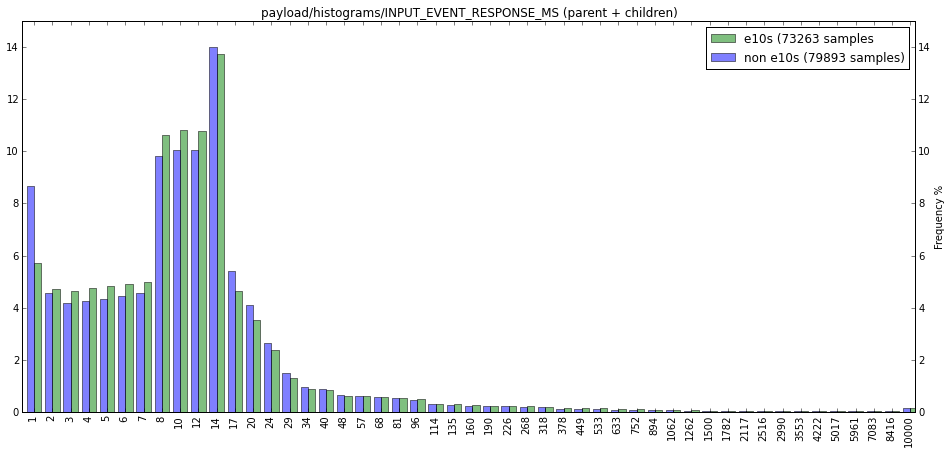

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent + children) are differing by chance is 0.00.


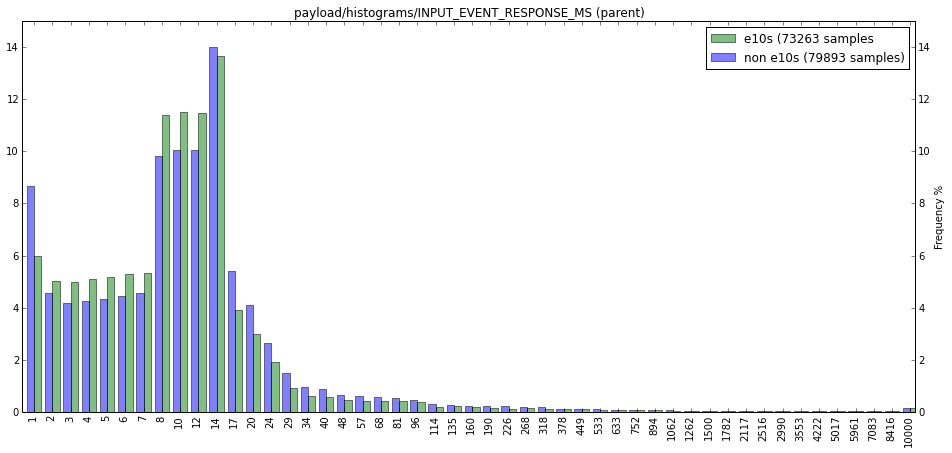

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent) are differing by chance is 0.00.


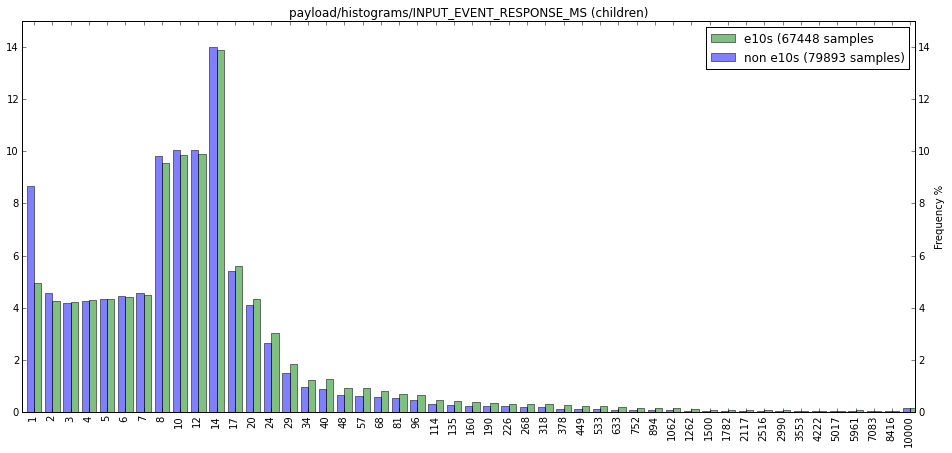

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (children) are differing by chance is 0.00.


In [8]:
compare_histograms(subset,
                   0,
                   "payload/histograms/INPUT_EVENT_RESPONSE_MS")

The one to look at is the parent+children plot. It shows the entire population of e10s input event timings vs the entire population of non-e10s input event timings.

The number of 0-1ms events is lower in e10s, but the number of 1-15ms events is higher. It seems as though, for the higher-speed events, e10s comes well within a 60fps frame timing (17ms) with at least as high a frequency as non-e10s events.

Users won't notice a change from 1ms to 2ms. The rule-of-thumb threshold for when a user expects a response to their input is 100ms, so we'll look at only those events in our next comparison.

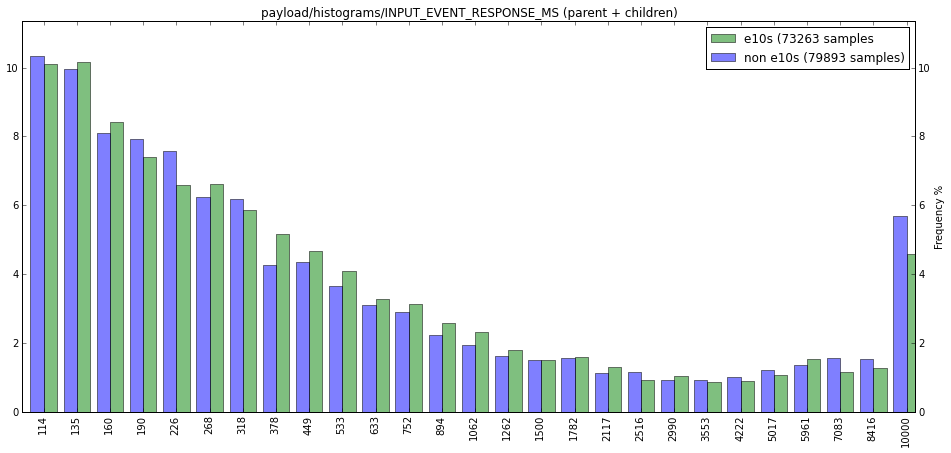

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent + children) are differing by chance is 0.10.


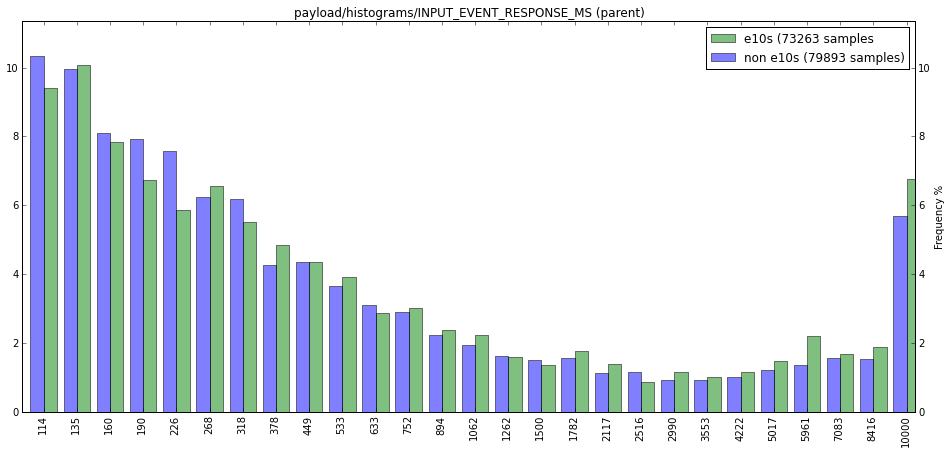

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent) are differing by chance is 0.02.


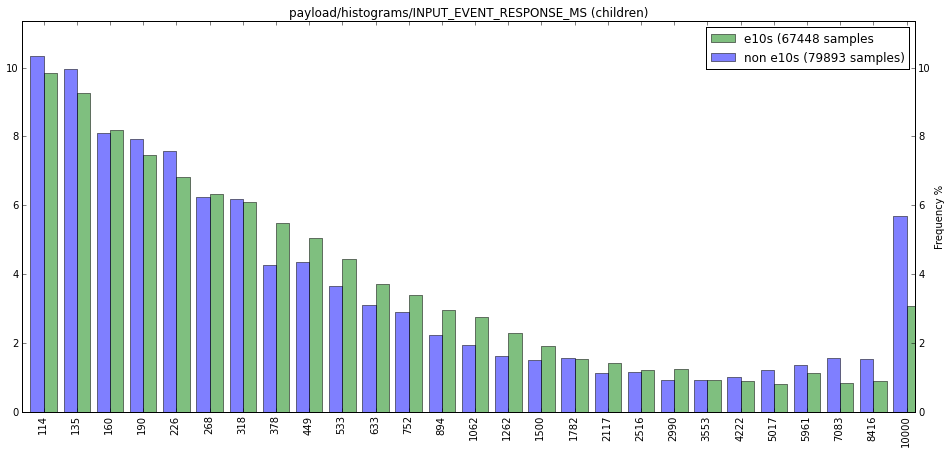

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (children) are differing by chance is 0.00.


In [9]:
compare_histograms(subset,
                   100,
                   "payload/histograms/INPUT_EVENT_RESPONSE_MS")

Some buckets show more e10s events and some show more non-e10s events. We can conclude that, in the jank threshold of input events taking > 100ms to process, e10s is no worse than non-e10s.

Do note the non-0 probability that the parent and parent+child plots differ by chance. This means that the small variances in the buckets may well be supplied by chance, not by any meaningful effect. Regardless, the conclusion still stands.